# Case Study: Students Performance in Exam
#### Author: Julio Venero
*July, 2021*


 ## Introduction
 This project purpose is to showcase some Data Wrangling and EDA techniques in Python.

 The dataset used for this case study was provided by Google/Coursera for the Google Data Analytics course.
 The data has been made available by Motivate International Inc. under this [license](https://www.divvybikes.com/data-license-agreement).

 ### About the data

 In 2016, Cyclistic launched a successful bike-share offering.
 Bikes can be unlocked from one station and returned to any other station in the system anytime.

 Princing plans:
 * Single-ride
 * Full-day
 * Annual membership

 ### Business Question: How do annual members and casual riders use Cyclistic bikes differently?

 ### Libraries to use:
 * Pandas for Data wrangling and Analysis
 * Numpy for Mathematical functions
 * Matlibplot and Seaborn for Data visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import haversine as hs

 ## Step 1: Importing the datasets and Initial exploration

 ### Concatenate all the file into a single dataframe
 Based on this [article on medium](https://medium.com/@kadek/elegantly-reading-multiple-csvs-into-pandas-e1a76843b688)


In [2]:
files = glob.glob('Data/*.csv')
tripdata = pd.concat([pd.read_csv(f) for f in files], ignore_index = True) # reset index

### Inspect the data

In [3]:
tripdata.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,02668AD35674B983,docked_bike,2020-05-27 10:03:52,2020-05-27 10:16:49,Franklin St & Jackson Blvd,36,Wabash Ave & Grand Ave,199.0,41.8777,-87.6353,41.8915,-87.6268,member
1,7A50CCAF1EDDB28F,docked_bike,2020-05-25 10:47:11,2020-05-25 11:05:40,Clark St & Wrightwood Ave,340,Clark St & Leland Ave,326.0,41.9295,-87.6431,41.9671,-87.6674,casual
2,2FFCDFDB91FE9A52,docked_bike,2020-05-02 14:11:03,2020-05-02 15:48:21,Kedzie Ave & Milwaukee Ave,260,Kedzie Ave & Milwaukee Ave,260.0,41.9296,-87.7079,41.9296,-87.7079,casual
3,58991CF1DB75BA84,docked_bike,2020-05-02 16:25:36,2020-05-02 16:39:28,Clarendon Ave & Leland Ave,251,Lake Shore Dr & Wellington Ave,157.0,41.9680,-87.6500,41.9367,-87.6368,casual
4,A79651EFECC268CD,docked_bike,2020-05-29 12:49:54,2020-05-29 13:27:11,Hermitage Ave & Polk St,261,Halsted St & Archer Ave,206.0,41.8715,-87.6699,41.8472,-87.6468,member


In [4]:
tripdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3742202 entries, 0 to 3742201
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 371.2+ MB


In [5]:
# Basic statistics for non-numerical variables
tripdata.describe(include='O')

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,member_casual
count,3742202,3742202,3742202,3742202,3593971,3593345,3570885,3570424.0,3742202
unique,3741993,3,3257750,3245372,711,1351,712,1353.0,2
top,84EEACD1FE641F30,docked_bike,2020-07-12 13:16:59,2020-07-15 11:44:46,Streeter Dr & Grand Ave,35,Streeter Dr & Grand Ave,35.0,member
freq,2,2498407,12,18,38524,32244,40552,34409.0,2198853


 ## Step 2: Data Wrangling

### 1. Ride ID cleaning
These Ids should be unique and without nulls or nans

In [6]:
# Look for duplicates
tripdata.duplicated(subset='ride_id').sum()

209

In [7]:
# Inspect the duplicated values
dupRideId = tripdata[tripdata.duplicated(subset='ride_id')]['ride_id'].tolist()
tripdata[tripdata['ride_id'].isin(dupRideId)].sort_values(['ride_id', 'started_at'])

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
2744807,021A73F8C18B932D,docked_bike,2020-11-25 16:35:39,2020-11-25 16:48:02,Clark St & Winnemac Ave,325.0,Ravenswood Ave & Berteau Ave,314.0,41.973347,-87.667855,41.957921,-87.673567,member
2921732,021A73F8C18B932D,docked_bike,2020-12-15 12:15:58,2020-11-25 16:48:02,Clark St & Winnemac Ave,TA1309000035,Ravenswood Ave & Berteau Ave,TA1309000018,41.973347,-87.667855,41.957921,-87.673567,member
2712746,0334987B57662109,docked_bike,2020-11-25 16:15:04,2020-11-25 16:22:04,Broadway & Berwyn Ave,294.0,Lakefront Trail & Bryn Mawr Ave,459.0,41.978353,-87.659753,41.984037,-87.652310,member
2935608,0334987B57662109,docked_bike,2020-12-15 11:56:33,2020-11-25 16:22:04,Broadway & Berwyn Ave,13109,Lakefront Trail & Bryn Mawr Ave,KA1504000152,41.978353,-87.659753,41.984037,-87.652310,member
2696545,038CAB4A84D9A56B,docked_bike,2020-11-25 16:08:05,2020-11-25 16:24:56,Wabash Ave & 9th St,321.0,Wabash Ave & 9th St,321.0,41.870769,-87.625734,41.870769,-87.625734,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947848,FE36876C99DE6E66,docked_bike,2020-12-15 12:17:51,2020-11-25 16:22:24,Clinton St & Roosevelt Rd,WL-008,State St & Randolph St,TA1305000029,41.867117,-87.641087,41.884730,-87.627734,member
2819076,FF1B35D974D5B39E,docked_bike,2020-11-25 19:18:20,2020-11-25 19:24:39,Sedgwick St & Huron St,111.0,Clark St & Elm St,176.0,41.894666,-87.638437,41.902973,-87.631280,casual
2902445,FF1B35D974D5B39E,docked_bike,2020-12-15 12:09:25,2020-11-25 19:24:39,Sedgwick St & Huron St,TA1307000062,Clark St & Elm St,TA1307000039,41.894666,-87.638437,41.902973,-87.631280,casual
2688210,FF49C6C596507F0B,docked_bike,2020-11-25 19:14:15,2020-11-25 19:27:10,Clark St & Randolph St,51.0,Aberdeen St & Jackson Blvd,21.0,41.884576,-87.631889,41.877726,-87.654787,member


 Since the percentage of duplicates is low, we will keep the most recent ones (started at) and drop the others

In [8]:
tripdata.sort_values(['ride_id', 'started_at'], inplace=True)
tripdata.drop_duplicates(subset='ride_id', keep='last', inplace=True)
tripdata.reset_index(drop=True)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,000001004784CD35,docked_bike,2020-07-22 15:38:23,2020-07-22 15:56:47,Wolcott (Ravenswood) Ave & Montrose Ave,238.0,Southport Ave & Clybourn Ave,307.0,41.961406,-87.676169,41.920771,-87.663712,casual
1,00000550C665101A,docked_bike,2020-06-06 15:20:01,2020-06-06 16:28:09,Sheffield Ave & Waveland Ave,114,Kedzie Ave & Milwaukee Ave,260.0,41.949399,-87.654529,41.929567,-87.707857,casual
2,0000127970C84F62,docked_bike,2020-05-30 06:36:36,2020-05-30 06:55:28,Green St & Madison St,198,Wells St & Concord Ln,289.0,41.881900,-87.648800,41.912100,-87.634700,member
3,00001A81D056B01B,classic_bike,2021-04-14 08:10:11,2021-04-14 08:19:14,Wood St & Hubbard St,13432,Morgan St & Lake St,TA1306000015,41.889899,-87.671473,41.885483,-87.652305,member
4,00001E17DEF40948,docked_bike,2020-07-08 21:45:01,2020-07-08 21:57:57,Wabash Ave & Roosevelt Rd,59.0,Indiana Ave & 26th St,147.0,41.867227,-87.625961,41.845687,-87.622481,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3741988,FFFFEE0233D826DE,docked_bike,2020-08-01 15:32:05,2020-08-01 15:56:51,Jefferson St & Monroe St,73.0,Dusable Harbor,6.0,41.880422,-87.642746,41.886976,-87.612813,casual
3741989,FFFFFB64C697B86A,docked_bike,2020-10-07 16:10:01,2020-10-07 16:45:28,Lake Shore Dr & Wellington Ave,157.0,Ashland Ave & Division St,210.0,41.936688,-87.636829,41.903450,-87.667747,member
3741990,FFFFFB6DD39792F1,docked_bike,2020-08-27 16:13:13,2020-08-27 16:43:24,McClurg Ct & Erie St,142.0,Halsted St & 18th St,202.0,41.894503,-87.617854,41.857499,-87.646277,member
3741991,FFFFFBF105061B9E,docked_bike,2020-06-15 08:52:25,2020-06-15 09:25:16,Avondale Ave & Irving Park Rd,483,Kildare Ave & Montrose Ave,630.0,41.953393,-87.732002,41.961080,-87.735690,member


In [9]:
# Validate there are no duplicated rows
tripdata.duplicated().sum()

0

There should not be missing values

In [10]:
tripdata['ride_id'].isnull().sum()

0

 They IDs should have the same length

In [11]:
tripdata['ride_id'].str.len().value_counts()

16    3741993
Name: ride_id, dtype: int64

 Ride Id is clean

### 2. Rideable type
This should be a categorical variable

Check for possible typos

In [12]:
tripdata['rideable_type'].value_counts()

docked_bike      2498198
electric_bike     709303
classic_bike      534492
Name: rideable_type, dtype: int64

In [13]:
# Convert to category
tripdata.loc[:,'rideable_type'] = tripdata['rideable_type'].astype('category')
tripdata['rideable_type'].dtypes

CategoricalDtype(categories=['classic_bike', 'docked_bike', 'electric_bike'], ordered=False)

### 3. Started At and Ended At
These two columns should be datetime instead of object

In [14]:
tripdata.dtypes

ride_id                 object
rideable_type         category
started_at              object
ended_at                object
start_station_name      object
start_station_id        object
end_station_name        object
end_station_id          object
start_lat              float64
start_lng              float64
end_lat                float64
end_lng                float64
member_casual           object
dtype: object

In [15]:
tripdata.loc[:,'started_at'] = tripdata['started_at'].astype('datetime64[ns]')
tripdata.loc[:,'ended_at'] = tripdata['ended_at'].astype('datetime64[ns]')
tripdata.dtypes

ride_id                       object
rideable_type               category
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
dtype: object

In [16]:
tripdata.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
630620,000001004784CD35,docked_bike,2020-07-22 15:38:23,2020-07-22 15:56:47,Wolcott (Ravenswood) Ave & Montrose Ave,238.0,Southport Ave & Clybourn Ave,307.0,41.961406,-87.676169,41.920771,-87.663712,casual
436881,00000550C665101A,docked_bike,2020-06-06 15:20:01,2020-06-06 16:28:09,Sheffield Ave & Waveland Ave,114,Kedzie Ave & Milwaukee Ave,260.0,41.949399,-87.654529,41.929567,-87.707857,casual
83106,0000127970C84F62,docked_bike,2020-05-30 06:36:36,2020-05-30 06:55:28,Green St & Madison St,198,Wells St & Concord Ln,289.0,41.881900,-87.648800,41.912100,-87.634700,member
3553991,00001A81D056B01B,classic_bike,2021-04-14 08:10:11,2021-04-14 08:19:14,Wood St & Hubbard St,13432,Morgan St & Lake St,TA1306000015,41.889899,-87.671473,41.885483,-87.652305,member
858067,00001E17DEF40948,docked_bike,2020-07-08 21:45:01,2020-07-08 21:57:57,Wabash Ave & Roosevelt Rd,59.0,Indiana Ave & 26th St,147.0,41.867227,-87.625961,41.845687,-87.622481,member


### 4. Start and End Stations
* Standardize
* Check for nulls

In [17]:
print("Are there numeric and non-numeric values as Ids?")
tripdata['end_station_id'].str.isnumeric().value_counts()

Are there numeric and non-numeric values as Ids?


False    433545
True     336437
Name: end_station_id, dtype: int64

In [18]:
print("What lenghts do we have in the Ids")
print("Station ID length")
print(tripdata['end_station_id'].str.len().value_counts())

What lenghts do we have in the Ids
Station ID length
12.0    393452
5.0     304141
3.0      37797
6.0      30544
4.0       2363
10.0      1176
7.0        420
35.0        78
8.0         11
Name: end_station_id, dtype: int64


In [19]:
print("Examples of ids with 35 characters")
print(tripdata[tripdata['end_station_id'].str.len() == 35]['end_station_id'])

print("")

print("Examples of ids with 12 characters")
print(tripdata[tripdata['end_station_id'].str.len() == 12]['end_station_id'])

print("")

print("Examples of ids with 10 characters")
print(tripdata[tripdata['end_station_id'].str.len() == 10]['end_station_id'])

print("")

print("Examples of ids with 3 characters")
print(tripdata[tripdata['end_station_id'].str.len() == 3]['end_station_id'])

Examples of ids with 35 characters
3322435    Hubbard Bike-checking (LBS-WH-TEST)
3106541    Hubbard Bike-checking (LBS-WH-TEST)
2927254    Hubbard Bike-checking (LBS-WH-TEST)
3528665    Hubbard Bike-checking (LBS-WH-TEST)
3043526    Hubbard Bike-checking (LBS-WH-TEST)
                          ...                 
3322354    Hubbard Bike-checking (LBS-WH-TEST)
2914466    Hubbard Bike-checking (LBS-WH-TEST)
2914419    Hubbard Bike-checking (LBS-WH-TEST)
3482314    Hubbard Bike-checking (LBS-WH-TEST)
2927423    Hubbard Bike-checking (LBS-WH-TEST)
Name: end_station_id, Length: 78, dtype: object

Examples of ids with 12 characters
3553991    TA1306000015
2940425    KA1504000159
3673650    TA1306000032
3600117    TA1307000117
3232606    KA1503000044
               ...     
3131251    TA1305000037
3729222    TA1305000003
3621444    TA1307000001
3283055    TA1308000001
3282919    TA1308000001
Name: end_station_id, Length: 393452, dtype: object

Examples of ids with 10 characters
3704114    K

In [20]:
print('Are there missing values?')
print('')

print('Looking for nulls on station ids')
print(str(len(tripdata[(tripdata['start_station_id'].isnull()) | (tripdata['end_station_id'].isnull())])) + ' nulls')

print('')

print('Looking for nulls on station names')
print(str(len(tripdata[(tripdata['start_station_name'].isnull()) | (tripdata['end_station_name'].isnull())])) + ' nulls')

Are there missing values?

Looking for nulls on station ids
233980 nulls

Looking for nulls on station names
233108 nulls


 Based on the previous validation:
 * There are numeric and alphanumeric Ids
 * There are many null values on station names

 The following steps should be taken:
 * If there are numeric IDs with decimal points, delete those to keep only the integer part
 * Create a master table of stations to fill the missing values

#### Delete the decimal part of numeric Ids

In [21]:
tripdata.loc[:,'start_station_id'] = tripdata['start_station_id'].astype('str').str.replace('\.0', '', regex=True)
tripdata.loc[:,'end_station_id'] = tripdata['end_station_id'].astype('str').str.replace('\.0', '', regex=True)

Validate

In [22]:
tripdata[tripdata['start_station_id'].astype('str').str.contains('\.0', na=False)]['start_station_id']

Series([], Name: start_station_id, dtype: object)

In [23]:
tripdata[tripdata['end_station_id'].astype('str').str.contains('\.0', na=False)]['end_station_id']

Series([], Name: end_station_id, dtype: object)

In [24]:
tripdata.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
630620,000001004784CD35,docked_bike,2020-07-22 15:38:23,2020-07-22 15:56:47,Wolcott (Ravenswood) Ave & Montrose Ave,238,Southport Ave & Clybourn Ave,307,41.961406,-87.676169,41.920771,-87.663712,casual
436881,00000550C665101A,docked_bike,2020-06-06 15:20:01,2020-06-06 16:28:09,Sheffield Ave & Waveland Ave,114,Kedzie Ave & Milwaukee Ave,260,41.949399,-87.654529,41.929567,-87.707857,casual
83106,0000127970C84F62,docked_bike,2020-05-30 06:36:36,2020-05-30 06:55:28,Green St & Madison St,198,Wells St & Concord Ln,289,41.881900,-87.648800,41.912100,-87.634700,member
3553991,00001A81D056B01B,classic_bike,2021-04-14 08:10:11,2021-04-14 08:19:14,Wood St & Hubbard St,13432,Morgan St & Lake St,TA1306000015,41.889899,-87.671473,41.885483,-87.652305,member
858067,00001E17DEF40948,docked_bike,2020-07-08 21:45:01,2020-07-08 21:57:57,Wabash Ave & Roosevelt Rd,59,Indiana Ave & 26th St,147,41.867227,-87.625961,41.845687,-87.622481,member


#### Create a master table for stations

 Clean and group the Ids and station names from start station columns

In [25]:
tripdata_bk = tripdata.copy()

In [26]:
tripdata.loc[:,'start_station_id'] = tripdata['start_station_id'].str.strip().str.lower()
tripdata.loc[:,'start_station_name'] = tripdata['start_station_name'].str.strip().str.title()
start_stations = tripdata.groupby(['start_station_id', 'start_station_name'], as_index=False).size()
start_stations = start_stations.rename(columns={'start_station_id':'station_id', 'start_station_name': 'station_name'}).drop('size', axis=1)

 Clean and group the Ids and station names from end station columns

In [27]:
tripdata.loc[:,'end_station_id'] = tripdata['end_station_id'].str.strip().str.lower()
tripdata.loc[:,'end_station_name'] = tripdata['end_station_name'].str.strip().str.title()
end_stations = tripdata.groupby(['end_station_id', 'end_station_name'], as_index=False).size()
end_stations = end_stations.rename(columns={'end_station_id': 'station_id', 'end_station_name': 'station_name'}).drop('size', axis=1)

In [28]:
# Reset the index to keep the records ordered (because of all the changes so far)
tripdata = tripdata.sort_values('ride_id').reset_index(drop=True)
tripdata.head()
# ALL OK TO THIS POINT

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,000001004784CD35,docked_bike,2020-07-22 15:38:23,2020-07-22 15:56:47,Wolcott (Ravenswood) Ave & Montrose Ave,238,Southport Ave & Clybourn Ave,307,41.961406,-87.676169,41.920771,-87.663712,casual
1,00000550C665101A,docked_bike,2020-06-06 15:20:01,2020-06-06 16:28:09,Sheffield Ave & Waveland Ave,114,Kedzie Ave & Milwaukee Ave,260,41.949399,-87.654529,41.929567,-87.707857,casual
2,0000127970C84F62,docked_bike,2020-05-30 06:36:36,2020-05-30 06:55:28,Green St & Madison St,198,Wells St & Concord Ln,289,41.881900,-87.648800,41.912100,-87.634700,member
3,00001A81D056B01B,classic_bike,2021-04-14 08:10:11,2021-04-14 08:19:14,Wood St & Hubbard St,13432,Morgan St & Lake St,ta1306000015,41.889899,-87.671473,41.885483,-87.652305,member
4,00001E17DEF40948,docked_bike,2020-07-08 21:45:01,2020-07-08 21:57:57,Wabash Ave & Roosevelt Rd,59,Indiana Ave & 26Th St,147,41.867227,-87.625961,41.845687,-87.622481,member


 Concatenate the previous dataframes into a single one and drop the duplicates

In [30]:
master_stations = pd.concat([start_stations, end_stations], axis=0, ignore_index=True).drop_duplicates().sort_values('station_id').reset_index(drop=True)
del start_stations, end_stations
master_stations.head()

,station_id,station_name
0,100,Orleans St & Merchandise Mart Plaza
1,101,63Rd St Beach
2,102,Stony Island Ave & 67Th St
3,103,Clinton St & Polk St
4,106,State St & Pearson St


In [31]:
# Number of Stations
len(master_stations)

1298

Check if there are duplicated station Ids

In [33]:
dupStationId = master_stations[master_stations.duplicated(subset='station_id')]['station_id'].tolist()
master_stations[master_stations['station_id'].isin(dupStationId)].sort_values('station_id')

,station_id,station_name
20,120,Wentworth Ave & Cermak Rd
21,120,Wentworth Ave & Cermak Rd (Temp)
59,13074,Broadway & Wilson Ave
60,13074,Broadway & Wilson - Truman College Vaccination...
317,19,Throop (Loomis) St & Taylor St
318,19,Throop St & Taylor St
330,20,Damen Ave & Wabansia Ave
331,20,Sheffield Ave & Kingsbury St
470,26,Mcclurg Ct & Illinois St
471,26,New St & Illinois St


 The names are similar, we can keep the shorter ones

 Notice that there are also a few **nan**s

Look for NULLS or nan IDs

In [34]:
master_stations[(master_stations['station_id']=='nan') | (master_stations['station_id'].isnull())]

,station_id,station_name
1116,nan,W Oakdale Ave & N Broadway
1117,nan,S Michigan Ave & E 118Th St
1118,nan,Hubbard_Test_Lws
1119,nan,N Clark St & W Elm St
1120,nan,W Armitage Ave & N Sheffield Ave


Look for NULLS or nan Names

In [35]:
master_stations[(master_stations['station_name']=='nan') | (master_stations['station_name'].isnull())]

,station_id,station_name


The following actions should be taken:
* Replace the nan with IDs if possible (from similar station names)
* Remove duplicated Ids

----
HANDLING NANS

In [36]:
nullIds = master_stations[master_stations['station_id'] == 'nan'].reset_index()
nullIds

,index,station_id,station_name
0,1116,nan,W Oakdale Ave & N Broadway
1,1117,nan,S Michigan Ave & E 118Th St
2,1118,nan,Hubbard_Test_Lws
3,1119,nan,N Clark St & W Elm St
4,1120,nan,W Armitage Ave & N Sheffield Ave


Let's check if there are records with the same names but with an appropriate ID

In [37]:
for i in nullIds['station_name']:
    print(i)
    print(master_stations[master_stations['station_name'] == i][['station_id', 'station_name']])
    print("")

W Oakdale Ave & N Broadway
     station_id                station_name
404       20252  W Oakdale Ave & N Broadway
1116        nan  W Oakdale Ave & N Broadway

S Michigan Ave & E 118Th St
     station_id                 station_name
1117        nan  S Michigan Ave & E 118Th St

Hubbard_Test_Lws
     station_id      station_name
1118        nan  Hubbard_Test_Lws

N Clark St & W Elm St
     station_id           station_name
402       20249  N Clark St & W Elm St
1119        nan  N Clark St & W Elm St

W Armitage Ave & N Sheffield Ave
     station_id                      station_name
406       20254  W Armitage Ave & N Sheffield Ave
1120        nan  W Armitage Ave & N Sheffield Ave



There were appropriate IDs for most of them.

Let's replace them

In [39]:
for i in nullIds['station_name']:
    correctID = master_stations[(master_stations['station_name'] == i) & (master_stations['station_id'] != 'nan')]['station_id'].max()
    master_stations.loc[(master_stations['station_name'] == i) & (master_stations['station_id'] == 'nan'),'station_id'] = correctID

Validate

In [40]:
nullIds = master_stations[(master_stations['station_id'] == 'nan') | (master_stations['station_id'].isnull())].reset_index(drop=True)
nullIds

,station_id,station_name
0,NaN,S Michigan Ave & E 118Th St
1,NaN,Hubbard_Test_Lws


There are 2 left

Let's look for similar names

In [41]:
master_stations[master_stations['station_name'].str.contains('Hubbard')]

,station_id,station_name
26,125,Rush St & Hubbard St
169,13432,Wood St & Hubbard St
238,15664,Artesian Ave & Hubbard St
420,212,Wells St & Hubbard St
497,285,Wood St & Hubbard St
592,376,Artesian Ave & Hubbard St
856,636,Orleans St & Hubbard St
898,671,Hubbard St Bike Checking (Lbs-Wh-Test)
996,hubbard bike-checking (lbs-wh-test),Base - 2132 W Hubbard Warehouse
997,hubbard bike-checking (lbs-wh-test),Hubbard St Bike Checking (Lbs-Wh-Test)


**Hubbard_Test_Lws** refers to **Hubbard St Bike Checking (Lbs-Wh-Test)**

We need to remove it from the master table and replace it with the correct values in the trip data

In [43]:
tripdata_bk = tripdata.copy() # CHECKPOINT

In [44]:
master_stations = master_stations[master_stations['station_name'] != 'Hubbard_Test_Lws']

# Start Station
tripdata.loc[tripdata['start_station_name'] == 'Hubbard_Test_Lws', ['start_station_id','start_station_name']] = ['671','Hubbard St Bike Checking (Lbs-Wh-Test)']
tripdata.loc[tripdata['start_station_name'] == 'Hubbard St Bike Checking (Lbs-Wh-Test)', 'start_station_id'] = '671'

# End Station
tripdata.loc[tripdata['end_station_name'] == 'Hubbard_Test_Lws', ['end_station_id','end_station_name']] = ['671','Hubbard St Bike Checking (Lbs-Wh-Test)']
tripdata.loc[tripdata['end_station_name'] == 'Hubbard St Bike Checking (Lbs-Wh-Test)', 'end_station_id'] = '671'

Let's proceed with the other case

In [46]:
master_stations[master_stations['station_name'].str.contains('Michigan')]

,station_id,station_name
33,13001,Michigan Ave & Washington St
44,13034,Michigan Ave & Pearson St
45,13036,Michigan Ave & Madison St
47,13042,Michigan Ave & Oak St
88,13150,Michigan Ave & 18Th St
262,168,Michigan Ave & 14Th St
326,197,Michigan Ave & Madison St
395,20243,Michigan Ave & 114Th St
459,25,Michigan Ave & Pearson St
484,273,Michigan Ave & 18Th St


There are no similar names, so we will identify that station with a new ID

In [47]:
# Which ID is available?
master_stations.query('station_id == "1000"')

,station_id,station_name


In [48]:
# Master Table
master_stations.loc[master_stations['station_name'] == 'S Michigan Ave & E 118Th St', 'station_id'] = '1000'

# Tripdata
tripdata.loc[tripdata['start_station_name'] == 'S Michigan Ave & E 118Th St', 'start_station_id'] = '1000'
tripdata.loc[tripdata['end_station_name'] == 'S Michigan Ave & E 118Th St', 'end_station_id'] = '1000'

C:\Users\julio\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\julio\anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Validate

In [49]:
master_stations[(master_stations['station_id'] == 'nan') | (master_stations['station_id'].isnull())]

,station_id,station_name


Remove duplicates and reset the index

In [51]:
master_stations = master_stations.drop_duplicates().sort_values('station_id').reset_index(drop=True)

----

**Remove duplicated IDs**

 Let's take a look at those duplicates

In [52]:
dupStationIds = master_stations[master_stations.duplicated(subset='station_id')]

In [53]:
dupStations = master_stations[master_stations['station_id'].isin(dupStationIds['station_id'].to_list())].sort_values('station_id')
dupStations

,station_id,station_name
21,120,Wentworth Ave & Cermak Rd
22,120,Wentworth Ave & Cermak Rd (Temp)
60,13074,Broadway & Wilson Ave
61,13074,Broadway & Wilson - Truman College Vaccination...
318,19,Throop (Loomis) St & Taylor St
319,19,Throop St & Taylor St
331,20,Sheffield Ave & Kingsbury St
332,20,Damen Ave & Wabansia Ave
471,26,Mcclurg Ct & Illinois St
472,26,New St & Illinois St


The names are similar, we can drop the duplicated rows

For dropping duplicated Station Ids, we will prioritize those with the shorter names

In [54]:
master_stations.loc[:,'order'] = master_stations['station_name'].str.len()
master_stations.sort_values(['station_id', 'order'], inplace=True)
master_stations.drop_duplicates(subset='station_id', keep='first', inplace=True)

Validate

In [55]:
master_stations[master_stations.duplicated(subset='station_id')]

,station_id,station_name,order


----

**Look for similar Station Names**

We may have cases of similar station names with different IDs

The FuzzyWuzzy package will help to find the most similar names by using the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance#:~:text=Informally%2C%20the%20Levenshtein%20distance%20between,considered%20this%20distance%20in%201965.)

In [56]:
from fuzzywuzzy import fuzz, process

In order to avoid those cases where the station names are almost the same but with a different number - fuzz score will be high -

(Example: California Ave & 21St St and California Ave & 26Th St), we will limit the search for stations without numbers

In [57]:
master_stations.duplicated(subset='station_id').sum()

0

In [58]:
def checkNum(x):
    return any(char.isdigit() for char in x)

str_master_stations = master_stations[~master_stations['station_name'].apply(checkNum)]

for i in str_master_stations['station_name']:
    matches = process.extract(i, master_stations['station_name'], limit=5, scorer=fuzz.token_sort_ratio)
    close_matches = [match[:2] for match in matches if  92 <= match[1] < 100]
    if close_matches:
        print(i,', ID:',str_master_stations.loc[str_master_stations['station_name'] == i, 'station_id'].values[0])
        print(close_matches, ', ID:', str_master_stations.loc[str_master_stations['station_name'] == close_matches[0][0], 'station_id'].values[0])
        print("")

Sheffield Ave & Wellington Ave , ID: 115
[('N Sheffield Ave & W Wellington Ave', 93)] , ID: 20256

N Hampden Ct & W Diversey Ave , ID: 20248
[('Hampden Ct & Diversey Ave', 92)] , ID: 202480

Hampden Ct & Diversey Ave , ID: 202480
[('N Hampden Ct & W Diversey Ave', 92)] , ID: 20248

N Sheffield Ave & W Wellington Ave , ID: 20256
[('Sheffield Ave & Wellington Ave', 93), ('Sheffield Ave & Wellington Ave', 93)] , ID: 115

Sheffield Ave & Wellington Ave , ID: 115
[('N Sheffield Ave & W Wellington Ave', 93)] , ID: 20256



We found 2 cases with similar names.

We will remove the longer names in the master table and replace those with their shorter version in the trip data

In [61]:
master_stations = master_stations[~master_stations['station_name'].isin(['N Hampden Ct & W Diversey Ave','N Sheffield Ave & W Wellington Ave'])]

# Start Station
tripdata.loc[tripdata['start_station_name'] == 'N Hampden Ct & W Diversey Ave', ['start_station_id','start_station_name']] = ['202480','Hampden Ct & Diversey Ave']
tripdata.loc[tripdata['end_station_name'] == 'N Hampden Ct & W Diversey Ave', ['end_station_id','end_station_name']] = ['202480','Hampden Ct & Diversey Ave']

# End Station
tripdata.loc[tripdata['start_station_name'] == 'N Sheffield Ave & W Wellington Ave', ['start_station_id','start_station_name']] = ['115','Sheffield Ave & Wellington Ave']
tripdata.loc[tripdata['end_station_name'] == 'N Sheffield Ave & W Wellington Ave', ['end_station_id','end_station_name']] = ['115','Sheffield Ave & Wellington Ave']

There should not be any duplicates now

In [63]:
master_stations.duplicated(subset='station_id').sum() +\
master_stations.duplicated().sum()

0

In [64]:
master_stations = master_stations.sort_values('station_id').reset_index(drop=True).drop('order', axis=1)

 **The master table is ready**

In [65]:
master_stations.head()

,station_id,station_name
0,100,Orleans St & Merchandise Mart Plaza
1,1000,S Michigan Ave & E 118Th St
2,101,63Rd St Beach
3,102,Stony Island Ave & 67Th St
4,103,Clinton St & Polk St


----

**Standardize the station's information**

In [67]:
tripdata = tripdata.sort_values('ride_id').reset_index(drop=True)

In [69]:
#tripdata_bk = tripdata.copy()

In [ ]:
#tripdata = tripdata_bk.copy()

In [ ]:
tripdata.head()

Replace the **nan**s with NaN

In [71]:
tripdata.loc[:,'start_station_id'] = tripdata['start_station_id'].replace('nan', np.nan)
tripdata.loc[:,'start_station_name'] = tripdata['start_station_name'].replace('nan', np.nan)

tripdata.loc[:,'end_station_id'] = tripdata['end_station_id'].replace('nan', np.nan)
tripdata.loc[:,'end_station_name'] = tripdata['end_station_name'].replace('nan', np.nan)

Join tripdata with master_stations to obtain the correct names

Before merging, validate that all IDs match

In [78]:
# Are there IDs that are not in master?
ss_merge = pd.merge(tripdata, master_stations, left_on='start_station_id', right_on='station_id', how='left', indicator=True)
es_merge = pd.merge(tripdata, master_stations, left_on='end_station_id', right_on='station_id', how='left', indicator=True)

In [79]:
print(ss_merge['_merge'].value_counts())
print(es_merge['_merge'].value_counts())

both          3593140
left_only       62414
right_only          0
Name: _merge, dtype: int64
both          3570218
left_only       85336
right_only          0
Name: _merge, dtype: int64


In [80]:
print(ss_merge[ss_merge['_merge']=='left_only']['start_station_id'].value_counts(dropna=False))
print(es_merge[es_merge['_merge']=='left_only']['end_station_id'].value_counts(dropna=False))

9999    61792
NaN       622
Name: start_station_id, dtype: int64
9999    84877
NaN       459
Name: end_station_id, dtype: int64


Everything is ok, only the missing values don´t match

In [81]:
del ss_merge, es_merge

Merge with master table to standardize the station names

In [82]:
tripdata = pd.merge(tripdata, master_stations, left_on='start_station_id', right_on='station_id', how='left')
tripdata.loc[:,'start_station_name'] = tripdata['station_name']
tripdata.drop(['station_id','station_name'], axis=1, inplace=True)

In [84]:
tripdata = pd.merge(tripdata, master_stations, left_on='end_station_id', right_on='station_id', how='left')
tripdata.loc[:,'end_station_name'] = tripdata['station_name']
tripdata.drop(['station_id','station_name'], axis=1, inplace=True)

In [85]:
tripdata.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,000001004784CD35,docked_bike,2020-07-22 15:38:23,2020-07-22 15:56:47,Wolcott (Ravenswood) Ave & Montrose Ave,238,Southport Ave & Clybourn Ave,307,41.961406,-87.676169,41.920771,-87.663712,casual
1,00000550C665101A,docked_bike,2020-06-06 15:20:01,2020-06-06 16:28:09,Sheffield Ave & Waveland Ave,114,Kedzie Ave & Milwaukee Ave,260,41.949399,-87.654529,41.929567,-87.707857,casual
2,0000127970C84F62,docked_bike,2020-05-30 06:36:36,2020-05-30 06:55:28,Green St & Madison St,198,Wells St & Concord Ln,289,41.881900,-87.648800,41.912100,-87.634700,member
3,00001A81D056B01B,classic_bike,2021-04-14 08:10:11,2021-04-14 08:19:14,Wood St & Hubbard St,13432,Morgan St & Lake St,ta1306000015,41.889899,-87.671473,41.885483,-87.652305,member
4,00001E17DEF40948,docked_bike,2020-07-08 21:45:01,2020-07-08 21:57:57,Wabash Ave & Roosevelt Rd,59,Indiana Ave & 26Th St,147,41.867227,-87.625961,41.845687,-87.622481,member


We know there are some stations without IDs, but with a name

We can search the appropriate ID using the name

But first, let's check if there are station names in tripdata, but not in the master table

In [111]:
ss_merge = pd.merge(tripdata, master_stations, left_on='start_station_name', right_on='station_name', how='left', indicator=True)
es_merge = pd.merge(tripdata, master_stations, left_on='end_station_name', right_on='station_name', how='left', indicator=True)

In [112]:
print(ss_merge['_merge'].value_counts())
print(es_merge['_merge'].value_counts())

both          7023420
left_only       62358
right_only          0
Name: _merge, dtype: int64
both          6977011
left_only       85280
right_only          0
Name: _merge, dtype: int64


In [93]:
print(ss_merge[ss_merge['_merge']=='left_only']['start_station_id'].value_counts(dropna=False))
print(es_merge[es_merge['_merge']=='left_only']['end_station_id'].value_counts(dropna=False))

9999    61792
NaN       622
Name: start_station_id, dtype: int64
9999    84877
NaN       459
Name: end_station_id, dtype: int64


There are duplicated names with different IDs
To avoid duplicated recored when merging both tables, we will need to create a master table with unique names

In [99]:
del ss_merge, es_merge

In [95]:
master_stations_n = master_stations.copy()

In [96]:
master_stations_n['order'] = np.where(master_stations_n['station_id'].str.isnumeric(), 1, master_stations_n['station_id'].str.len())
master_stations_n.sort_values(['station_name','order'], inplace=True)
master_stations_n.drop_duplicates(subset='station_name', keep='first', inplace=True)

In [98]:
master_stations_n.duplicated(subset='station_name').sum()

0

Now we can merge

In [118]:
# Start Stations
tripdata = pd.merge(tripdata, master_stations_n, left_on='start_station_name', right_on='station_name', how='left')
tripdata.loc[:,'start_station_id'] = np.where(tripdata['start_station_id'].isnull(), tripdata['station_id'], tripdata['start_station_id'])
tripdata.drop(['station_id','station_name'], axis=1, inplace=True)

# End Stations
tripdata = pd.merge(tripdata, master_stations_n, left_on='end_station_name', right_on='station_name', how='left')
tripdata.loc[:,'end_station_id'] = np.where(tripdata['end_station_id'].isnull(), tripdata['station_id'], tripdata['end_station_id'])
tripdata.drop(['station_id','station_name'], axis=1, inplace=True)

Remove those cases where the station id and name are missing for both start and end stations

In [119]:
tripdata = tripdata[~((tripdata['start_station_id'].isnull()) & (tripdata['start_station_name'].isnull())\
                    & (tripdata['end_station_id'].isnull()) & (tripdata['end_station_name'].isnull()))]

Validate there are no longer "nan" values or nulls

In [121]:
print('Looking for nulls on station ids')
print(str(len(tripdata[(tripdata['start_station_id'].isnull()) | (tripdata['end_station_id'].isnull())])) + ' nulls')

print('')

print('Looking for nulls on station names')
print(str(len(tripdata[(tripdata['start_station_name'].isnull()) | (tripdata['end_station_name'].isnull())])) + ' nulls')

There are still some nulls, let's check

In [122]:
tripdata[tripdata['start_station_name'].isnull()]['start_station_id'].value_counts(dropna=False)

9999    61792
NaN       566
Name: start_station_id, dtype: int64

In [123]:
tripdata[tripdata['end_station_name'].isnull()]['end_station_id'].value_counts(dropna=False)

9999    84877
NaN       403
Name: end_station_id, dtype: int64

In [127]:
print(len(tripdata[(tripdata['start_station_id'].isnull()) & ~(tripdata['start_station_name'].isnull())]))
print(len(tripdata[(tripdata['end_station_id'].isnull()) & ~(tripdata['end_station_name'].isnull())]))

0
0


In all the cases, we have both the id and name equal to null

For those cases, replace the IDs with 9999 and names with 'Unknown'

In [128]:
# Start Stations
tripdata['start_station_id'] = np.where(tripdata['start_station_id'].isnull(), '9999', tripdata['start_station_id'])
tripdata['start_station_name'] = np.where(tripdata['start_station_name'].isnull(), 'Unknown', tripdata['start_station_name'])
# End Stations
tripdata['end_station_id'] = np.where(tripdata['end_station_id'].isnull(), '9999', tripdata['end_station_id'])
tripdata['end_station_name'] = np.where(tripdata['end_station_name'].isnull(), 'Unknown', tripdata['end_station_name'])

Validate

In [130]:
print('Looking for nulls on station ids')
print(str(len(tripdata[(tripdata['start_station_id'].isnull()) | (tripdata['end_station_id'].isnull())])) + ' nulls')

print('')

print('Looking for nulls on station names')
print(str(len(tripdata[(tripdata['start_station_name'].isnull()) | (tripdata['end_station_name'].isnull())])) + ' nulls')

Looking for nulls on station ids
0 nulls

Looking for nulls on station names
0 nulls


 The station names are clean now

 We can proceed with the other variables

In [116]:
tripdata.dtypes


ride_id                       object
rideable_type               category
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
order_x                      float64
order_y                      float64
dtype: object

The types are correct now, but we still need to check that the results make sense.

### 6. Start and End Dates
For this case, we should check that the ended_at date always occurs after the started_at date

In [131]:
len(tripdata[tripdata['started_at'] > tripdata['ended_at']])



10470

In [132]:
tripdata[tripdata['started_at'] > tripdata['ended_at']].head()


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,order_x,order_y
219,0003D0AA1F7CEAC8,docked_bike,2020-08-23 12:10:56,2020-08-23 12:10:40,Clark St & Chicago Ave,337,Noble St & Milwaukee Ave,29,41.896750,-87.630890,41.900680,-87.662600,casual,1.0,1.0
1342,00183B358D2A454A,docked_bike,2020-06-07 14:28:51,2020-06-07 14:28:44,Clark St & Wellington Ave,156,Milwaukee Ave & Grand Ave,84,41.936496,-87.647538,41.891578,-87.648384,casual,1.0,1.0
3208,003A706B9EDAF788,docked_bike,2020-07-16 19:21:11,2020-07-16 19:21:02,Ritchie Ct & Banks St,180,Lasalle St & Illinois St,181,41.906866,-87.626217,41.890762,-87.631697,member,1.0,1.0
3339,003CB4B59125E2F8,docked_bike,2020-08-22 14:35:01,2020-08-22 14:34:50,Wilton Ave & Diversey Pkwy,13,Lake Shore Dr & Belmont Ave,334,41.932418,-87.652705,41.940775,-87.639192,member,1.0,1.0
3909,0047A30D1BA47B7A,docked_bike,2020-09-05 15:32:38,2020-09-05 15:32:26,Lincoln Ave & Fullerton Ave,127,Southport Ave & Wrightwood Ave,190,41.925905,-87.649260,41.928773,-87.663913,casual,1.0,1.0


 There is a way to estimate the correct ended_at time.

 For this, we will need to calculate the traveled distance using the [Haversine Distance Formula](https://towardsdatascience.com/calculating-distance-between-two-geolocations-in-python-26ad3afe287b)

### 7. Enrich the data: calculate the travel distance and time

 Haversine will return the distance (km) based on the coordinates.

In [133]:
def getDistance(row):
    dist = hs.haversine((row['start_lat'], row['start_lng']), (row['end_lat'], row['end_lng']))
    return dist


tripdata['distance_km'] = tripdata.apply(getDistance, axis=1).round(4)
tripdata.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,order_x,order_y,distance_km
0,000001004784CD35,docked_bike,2020-07-22 15:38:23,2020-07-22 15:56:47,Wolcott (Ravenswood) Ave & Montrose Ave,238,Southport Ave & Clybourn Ave,307,41.961406,-87.676169,41.920771,-87.663712,casual,1.0,1.0,4.6344
1,00000550C665101A,docked_bike,2020-06-06 15:20:01,2020-06-06 16:28:09,Sheffield Ave & Waveland Ave,114,Kedzie Ave & Milwaukee Ave,260,41.949399,-87.654529,41.929567,-87.707857,casual,1.0,1.0,4.9314
2,0000127970C84F62,docked_bike,2020-05-30 06:36:36,2020-05-30 06:55:28,Green St & Madison St,198,Wells St & Concord Ln,289,41.881900,-87.648800,41.912100,-87.634700,member,1.0,1.0,3.5551
3,00001A81D056B01B,classic_bike,2021-04-14 08:10:11,2021-04-14 08:19:14,Wood St & Hubbard St,13432,Morgan St & Lake St,ta1306000015,41.889899,-87.671473,41.885483,-87.652305,member,1.0,1.0,1.6610
4,00001E17DEF40948,docked_bike,2020-07-08 21:45:01,2020-07-08 21:57:57,Wabash Ave & Roosevelt Rd,59,Indiana Ave & 26Th St,147,41.867227,-87.625961,41.845687,-87.622481,member,1.0,1.0,2.4124


 First, add the time column (hours)

In [134]:
tripdata['time_h'] = ((tripdata['ended_at'] - tripdata['started_at'])/pd.Timedelta('1h')).round(4)

 Then, calculate the speed (km/h)

In [135]:
tripdata['speed'] = round(tripdata['distance_km'] / tripdata['time_h'], 4)

 Finally, we will calculate the average speed and use that value to determine the correct time for those observations with an end time happening before the start time

Let's create a dataframe that contains only those observations with start/end time that make sense

In [136]:
tempTripData = tripdata[tripdata['ended_at'] > tripdata['started_at']]

Then, check the results

In [137]:
tempTripData.sort_values('speed', ascending=False)[['started_at', 'ended_at', 'distance_km', 'time_h', 'speed']].head()

,started_at,ended_at,distance_km,time_h,speed
180754,2020-10-16 13:31:10,2020-10-16 13:31:36,25.2394,0.0072,3505.4722
876511,2020-11-11 11:38:23,2020-11-11 11:38:47,14.4822,0.0067,2161.5224
3268012,2020-11-21 08:06:11,2020-11-21 08:06:12,0.6147,0.0003,2049.0000
846370,2021-04-07 22:41:46,2021-04-07 22:41:47,0.5509,0.0003,1836.3333
3532492,2020-09-25 14:30:36,2020-09-25 14:31:00,11.4083,0.0067,1702.7313


 We have values that doesn't make sense (Ej: 1km in 1 ms)
 According to this [website](https://sustainabilityinfo.com/transportation/what-is-the-average-speed-for-urban-cycling/#:~:text=On%20average%2C%20urban%20cycling%20has,your%20average%20daily%20commute%20duration.), the average urban cycling speed is around 19-26 km/h
 We can define a maximum of 30 km/h, let's check how many rides are above that number

In [138]:
print("Total rides with outlier speed: " + str((tempTripData['speed'] > 30).sum()))
print("Total observations: " + str(len(tempTripData)))
print("Percentage: " + str(100 * (tempTripData['speed'] > 30).sum() / len(tempTripData)) + '%')

Total rides with outlier speed: 3198
Total observations: 3644620
Percentage: 0.08774577322189968%


The percentage is very low, we can remove those observations

In [139]:
tempTripData = tempTripData[tempTripData['speed'] <= 30]

Let's see the distribution of speeds

<AxesSubplot:xlabel='speed', ylabel='Count'>

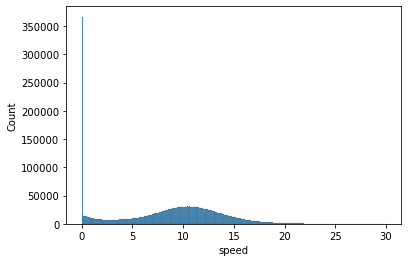

In [140]:
sns.histplot(data=tempTripData, x='speed')

Looks like that there are a lot of 0s

In [141]:
(tempTripData['speed'] == 0).sum()

308068

In [142]:
tempTripData[tempTripData['speed'] == 0][['started_at', 'ended_at', 'distance_km', 'time_h', 'speed']].head()

,started_at,ended_at,distance_km,time_h,speed
31,2021-03-08 17:48:21,2021-03-08 18:01:40,0.0,0.2219,0.0
33,2020-08-24 09:26:35,2020-08-24 09:46:54,0.0,0.3386,0.0
38,2020-09-20 23:16:24,2020-09-20 23:18:16,0.0,0.0311,0.0
46,2021-03-13 00:48:47,2021-03-13 01:51:12,0.0,1.0403,0.0
53,2020-09-21 19:17:17,2020-09-21 19:17:38,0.0,0.0058,0.0


We can see that the distance between the start station and the end station is not the same as the distance traveled.

A rider could just ride around the same station or take a different path.

This makes the calculated distance incorrect, we need the distance to be tracked

Since there is no way to fix the incorrect ended_at values (without the distance data), we will drop those rows

In [143]:
del tempTripData

In [144]:
tripdata = tripdata[tripdata['time_h'] > 0]

Drop the speed column and rename the distance column

In [145]:
tripdata.rename(columns={'distance_km': 'distance_stations_km'}, inplace=True)
tripdata.drop('speed', axis=1, inplace=True)
tripdata.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,order_x,order_y,distance_stations_km,time_h
0,000001004784CD35,docked_bike,2020-07-22 15:38:23,2020-07-22 15:56:47,Wolcott (Ravenswood) Ave & Montrose Ave,238,Southport Ave & Clybourn Ave,307,41.961406,-87.676169,41.920771,-87.663712,casual,1.0,1.0,4.6344,0.3067
1,00000550C665101A,docked_bike,2020-06-06 15:20:01,2020-06-06 16:28:09,Sheffield Ave & Waveland Ave,114,Kedzie Ave & Milwaukee Ave,260,41.949399,-87.654529,41.929567,-87.707857,casual,1.0,1.0,4.9314,1.1356
2,0000127970C84F62,docked_bike,2020-05-30 06:36:36,2020-05-30 06:55:28,Green St & Madison St,198,Wells St & Concord Ln,289,41.881900,-87.648800,41.912100,-87.634700,member,1.0,1.0,3.5551,0.3144
3,00001A81D056B01B,classic_bike,2021-04-14 08:10:11,2021-04-14 08:19:14,Wood St & Hubbard St,13432,Morgan St & Lake St,ta1306000015,41.889899,-87.671473,41.885483,-87.652305,member,1.0,1.0,1.6610,0.1508
4,00001E17DEF40948,docked_bike,2020-07-08 21:45:01,2020-07-08 21:57:57,Wabash Ave & Roosevelt Rd,59,Indiana Ave & 26Th St,147,41.867227,-87.625961,41.845687,-87.622481,member,1.0,1.0,2.4124,0.2156


### 8. Member Type
To finalize the data wrangling process, let's clean the last variable: member_casual

In [146]:
tripdata['member_casual'].value_counts()

member    2138202
casual    1506418
Name: member_casual, dtype: int64

Everything is clean.

The data is ready for analysis